# YOLO Training for Chart and Table Detection
This notebook implements training of a YOLOv8 model for detecting charts and tables in images.

In [1]:
!nvidia-smi

Thu Jun  5 13:26:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Environment Setup
Checking GPU availability and setting up the working environment.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [3]:
# Pip install method (recommended)

!pip install ultralytics==8.2.103 -q

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.103 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.7/112.6 GB disk)


## Package Installation
Installing required packages including ultralytics.

In [4]:
from ultralytics import YOLO

from IPython.display import display, Image

In [5]:
%cd {HOME}/datasets
!pip install roboflow==1.1.48 --quiet

# Download the chart dataset
import roboflow
roboflow.login()  # For interactive login

# If you have API key, use this instead:
# rf = Roboflow(api_key="your_roboflow_api_key")
rf = roboflow.Roboflow()

# Download chart dataset
chart_project = rf.workspace("alex-poon-xn1p2").project("viz3")
chart_dataset = chart_project.version(1).download("yolov8")

# Download table dataset (using your provided code)
rf = roboflow.Roboflow(api_key="cy188Qjis5GTDw7drjWN")
table_project = rf.workspace("firsttrywithyolo").project("table-detection-czyup")
table_dataset = table_project.version(1).download("yolov8")


[Errno 2] No such file or directory: '/content/datasets'
/content
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 17.6 MB/s eta 0:00:00
visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to viz3-1 in yolov8:: 100%|██████████| 11754/11754 [00:02<00:00, 4063.54it/s]


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Table-detection-1 in yolov8:: 100%|██████████| 10820/10820 [00:01<00:00, 6239.93it/s]


## Dataset Preparation
Downloading and setting up the chart and table datasets from Roboflow.

In [6]:
from ultralytics import YOLO
from IPython.display import display, Image
import glob
import shutil
import yaml

combined_dataset_dir = f"{HOME}/datasets/combined_charts_tables"
!mkdir -p {combined_dataset_dir}
!mkdir -p {combined_dataset_dir}/train/images
!mkdir -p {combined_dataset_dir}/train/labels
!mkdir -p {combined_dataset_dir}/valid/images
!mkdir -p {combined_dataset_dir}/valid/labels
!mkdir -p {combined_dataset_dir}/test/images
!mkdir -p {combined_dataset_dir}/test/labels

# Function to copy files and adjust labels
def combine_datasets(chart_dataset_path, table_dataset_path, combined_dataset_dir):
    # Load chart dataset YAML
    with open(f"{chart_dataset_path}/data.yaml", 'r') as file:
        chart_yaml = yaml.safe_load(file)

    # Load table dataset YAML
    with open(f"{table_dataset_path}/data.yaml", 'r') as file:
        table_yaml = yaml.safe_load(file)

    # Get class names from both datasets
    chart_classes = chart_yaml.get('names', {})
    table_classes = table_yaml.get('names', {})

    # Convert lists to dictionaries if needed
    if isinstance(chart_classes, list):
        chart_classes = {i: name for i, name in enumerate(chart_classes)}
    if isinstance(table_classes, list):
        table_classes = {i: name for i, name in enumerate(table_classes)}

    # Create a combined class list
    # For table dataset, we need to offset the class IDs
    chart_class_count = len(chart_classes)

    # Create combined names dictionary
    combined_names = chart_classes.copy()

    # Add table classes with offset
    for i, name in table_classes.items():
        if isinstance(i, str):  # Handle string indices
            i = int(i)
        combined_names[chart_class_count + i] = name

    # Copy and adjust files for each split (train, valid, test)
    for split in ['train', 'valid', 'test']:
        # Copy chart images and labels
        chart_img_dir = f"{chart_dataset_path}/{split}/images"
        chart_lbl_dir = f"{chart_dataset_path}/{split}/labels"

        if os.path.exists(chart_img_dir):
            for img_file in os.listdir(chart_img_dir):
                shutil.copy(
                    f"{chart_img_dir}/{img_file}",
                    f"{combined_dataset_dir}/{split}/images/{img_file}"
                )

            for lbl_file in os.listdir(chart_lbl_dir):
                shutil.copy(
                    f"{chart_lbl_dir}/{lbl_file}",
                    f"{combined_dataset_dir}/{split}/labels/{lbl_file}"
                )

        # Copy table images and adjust labels
        table_img_dir = f"{table_dataset_path}/{split}/images"
        table_lbl_dir = f"{table_dataset_path}/{split}/labels"

        if os.path.exists(table_img_dir):
            for img_file in os.listdir(table_img_dir):
                # Add prefix to avoid filename collisions
                new_img_file = f"table_{img_file}"
                shutil.copy(
                    f"{table_img_dir}/{img_file}",
                    f"{combined_dataset_dir}/{split}/images/{new_img_file}"
                )

            for lbl_file in os.listdir(table_lbl_dir):
                new_lbl_file = f"table_{lbl_file}"

                # Read original label file
                with open(f"{table_lbl_dir}/{lbl_file}", 'r') as file:
                    lines = file.readlines()

                # Adjust class IDs by adding chart_class_count
                adjusted_lines = []
                for line in lines:
                    parts = line.strip().split()
                    if parts:
                        class_id = int(parts[0])
                        adjusted_class_id = class_id + chart_class_count
                        adjusted_line = f"{adjusted_class_id} {' '.join(parts[1:])}\n"
                        adjusted_lines.append(adjusted_line)

                # Write adjusted labels
                with open(f"{combined_dataset_dir}/{split}/labels/{new_lbl_file}", 'w') as file:
                    file.writelines(adjusted_lines)

    # Create combined data.yaml
    combined_yaml = {
        'path': combined_dataset_dir,
        'train': 'train/images',
        'val': 'valid/images',
        'test': 'test/images',
        'names': combined_names
    }

    with open(f"{combined_dataset_dir}/data.yaml", 'w') as file:
        yaml.dump(combined_yaml, file, sort_keys=False)

    return combined_yaml

# Combine the datasets
combined_yaml = combine_datasets(chart_dataset.location, table_dataset.location, combined_dataset_dir)

# Print the combined class names
print("Combined class names:")
for class_id, class_name in combined_yaml['names'].items():
    print(f"{class_id}: {class_name}")


Combined class names:
0: donut
1: hbar
2: hbar_stacked
3: legend
4: line
5: pie
6: vbar
7: vbar_line
8: vbar_stacked
9: table


## Dataset Combination
Combining chart and table datasets into a single unified dataset for training.

In [7]:
%cd {HOME}

# Define model configuration
model_name = "yolov8l.pt"  # Using YOLOv8 large model
epochs = 25  # Increased epochs for better learning on combined dataset
image_size = 640  # Keep the image size at 800px

# Training with your successful hyperparameters
!yolo task=detect mode=train \
    model={model_name} \
    data={combined_dataset_dir}/data.yaml \
    epochs={epochs} \
    imgsz={image_size} \
    plots=True \
    augment=True \
    degrees=5 \
    scale=0.5 \
    hsv_h=0.01 \
    batch=16 \
    lr0=0.01 \
    lrf=0.0001 \
    warmup_epochs=3 \
    pretrained=True \
    patience=5  # Added patience parameter for early stopping

/content
100% 83.7M/83.7M [00:00<00:00, 122MB/s]
New https://pypi.org/project/ultralytics/8.3.150 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.103 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/datasets/combined_charts_tables/data.yaml, epochs=25, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=

## Custom Training

/content


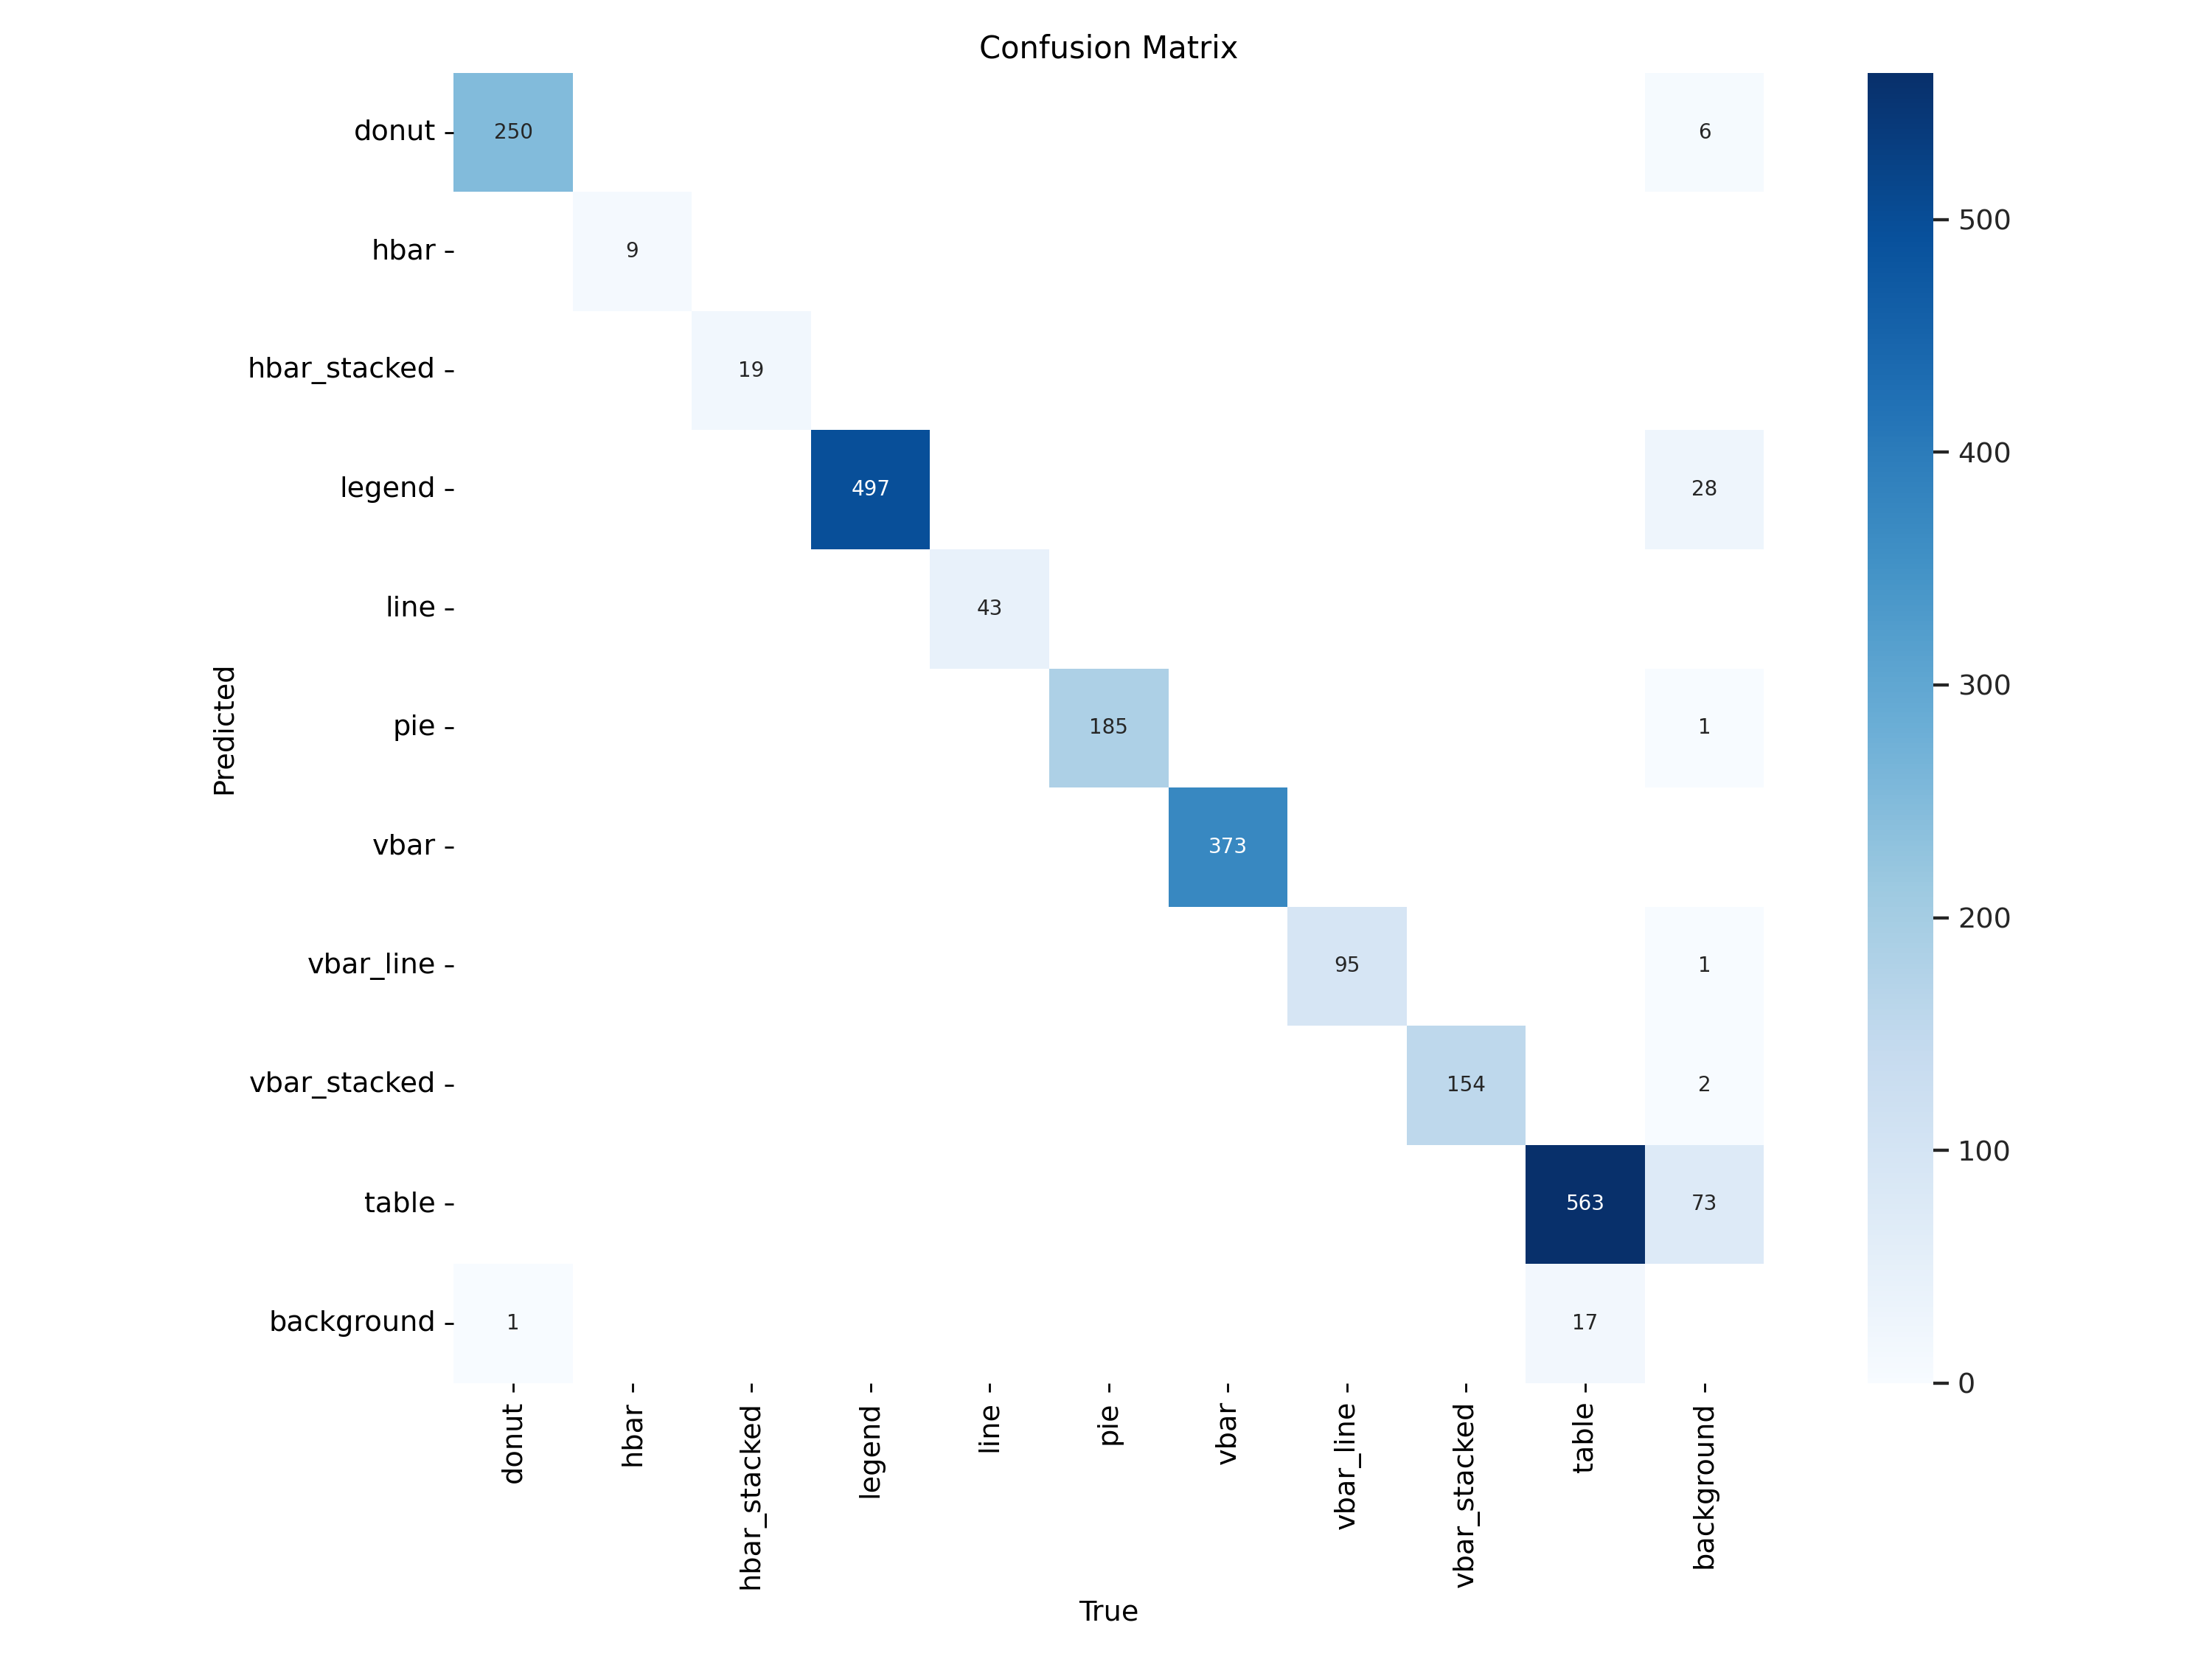

In [9]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

## Training Results Visualization
Viewing the training results through confusion matrix and performance plots.

/content


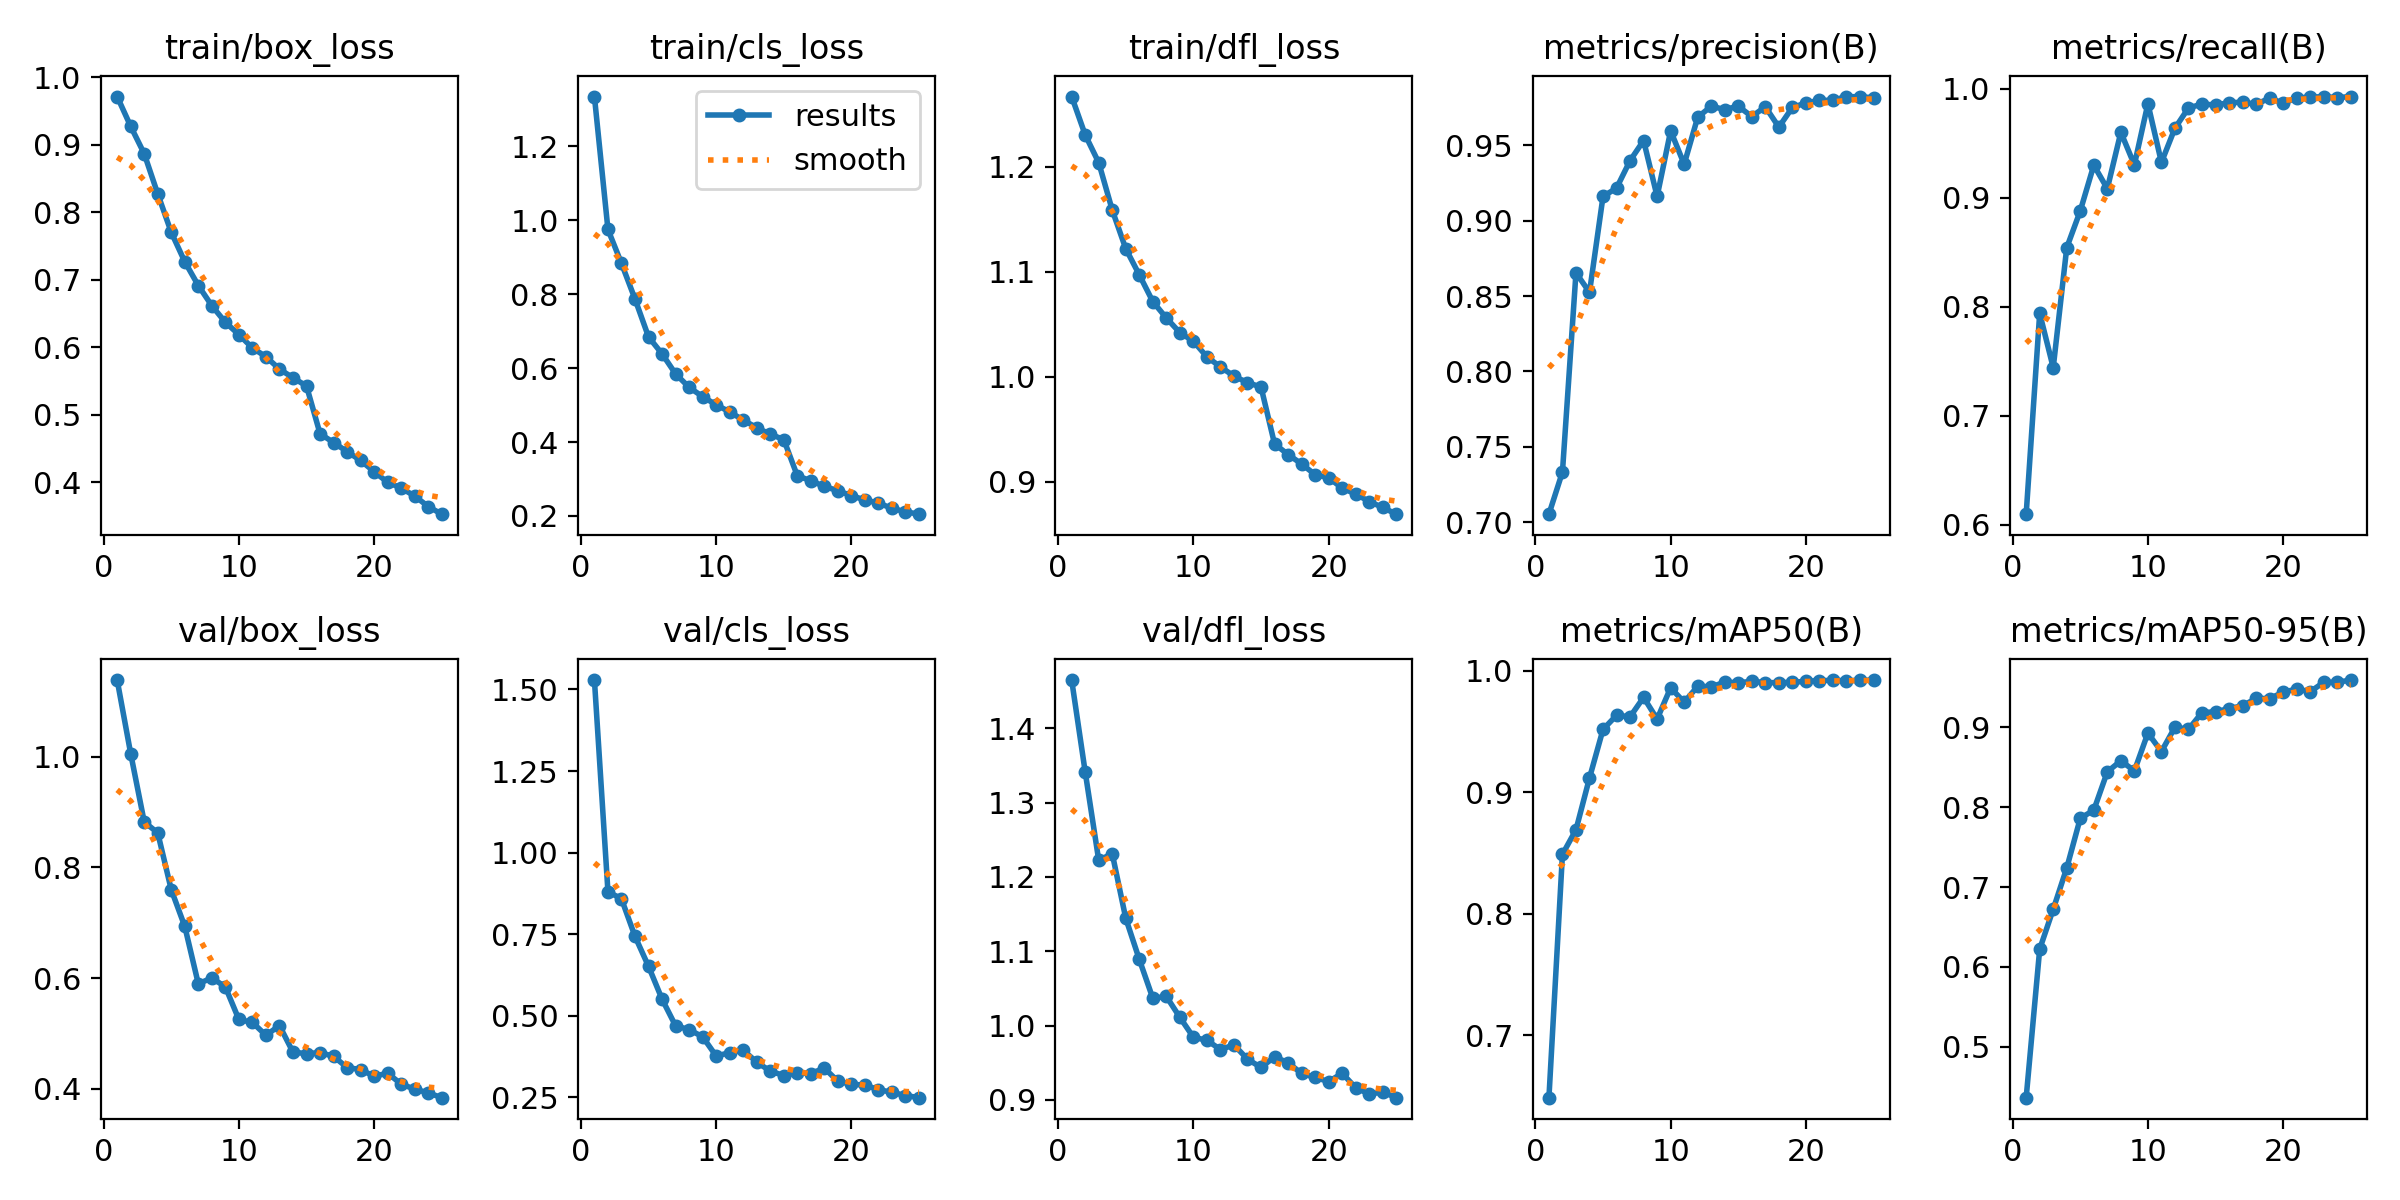

In [10]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

/content


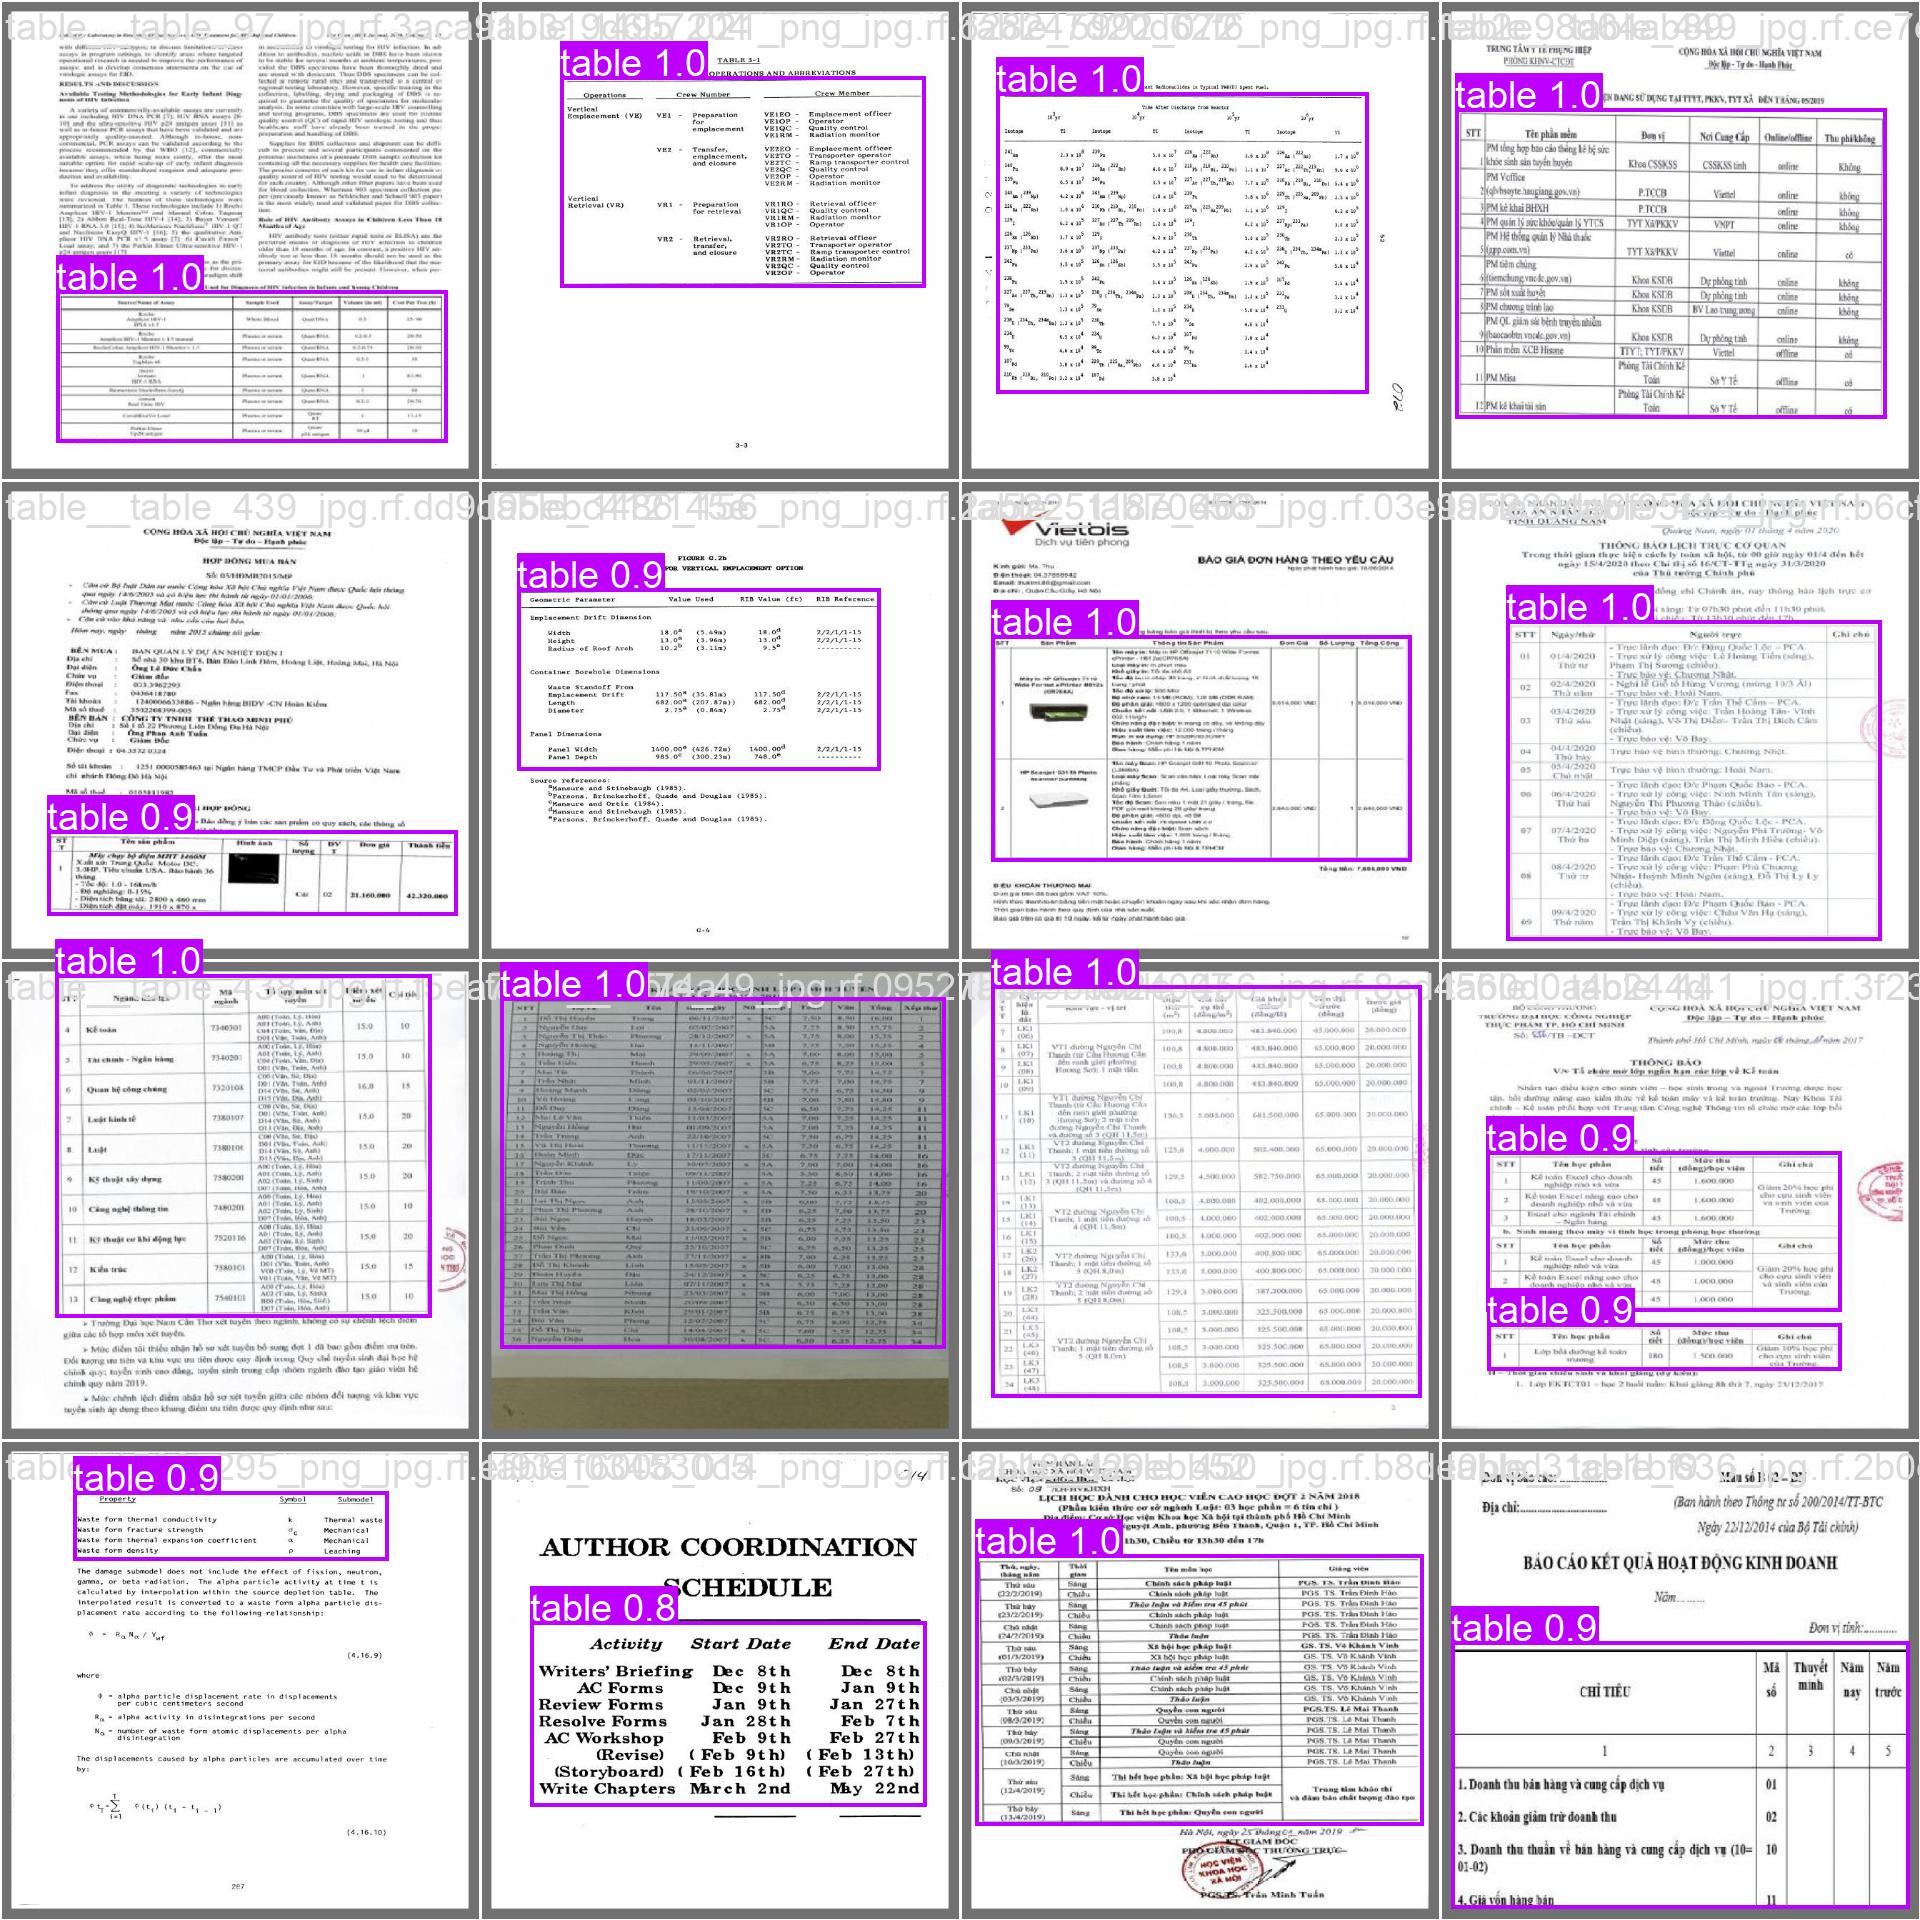

In [11]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate Custom Model

In [ ]:
%cd {HOME}

!yolo task=detect mode=val model=/content/runs/detect/train/weights/best.pt data=/content/datasets/combined_charts_tables/data.yaml

/content
Ultralytics YOLOv8.2.103 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 268 layers, 43,614,318 parameters, 0 gradients, 164.9 GFLOPs
val: Scanning /content/datasets/combined_charts_tables/valid/labels.cache... 950 images, 0 backgrounds, 0 corrupt: 100% 950/950 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 60/60 [00:31<00:00,  1.92it/s]
                   all        950       2206      0.982      0.993      0.992       0.96
                 donut        117        251      0.991      0.996      0.994      0.948
                  hbar          8          9      0.966          1      0.995      0.995
          hbar_stacked         11         19      0.982          1      0.995      0.967
                legend        305        497      0.992      0.979      0.991      0.875
                  line         32         43      0.992          1      0.995      0.968
              

## Inference with Custom Model

In [ ]:
%cd {HOME}
!yolo task=detect mode=predict model=/content/runs/detect/train/weights/best.pt conf=0.25 source=/content/datasets/combined_charts_tables/test/images save=True

/content
Ultralytics YOLOv8.2.103 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 268 layers, 43,614,318 parameters, 0 gradients, 164.9 GFLOPs

image 1/469 /content/datasets/combined_charts_tables/test/images/2019112100372_015_jpg.rf.5316f631449ad620805a4e728c260867.jpg: 640x480 1 legend, 1 vbar_line, 60.1ms
image 2/469 /content/datasets/combined_charts_tables/test/images/2019112100372_015_jpg.rf.c19287b2b1116fa4f96289491c7b0053.jpg: 640x480 1 legend, 1 vbar_line, 35.9ms
image 3/469 /content/datasets/combined_charts_tables/test/images/2019112100372_016_jpg.rf.4838f30ef1d99a1cd46cd39ed261252a.jpg: 640x480 2 legends, 2 vbar_lines, 35.7ms
image 4/469 /content/datasets/combined_charts_tables/test/images/2019112100372_016_jpg.rf.7824e06ec6f77da08ac8799fd343029f.jpg: 640x480 2 legends, 2 vbar_lines, 35.7ms
image 5/469 /content/datasets/combined_charts_tables/test/images/2019112100372_022_jpg.rf.389021efc0c0794cc00bc2c7cabfb38b.jpg: 640x480 1 pie, 35.7ms


**NOTE:** Let's take a look at few results.

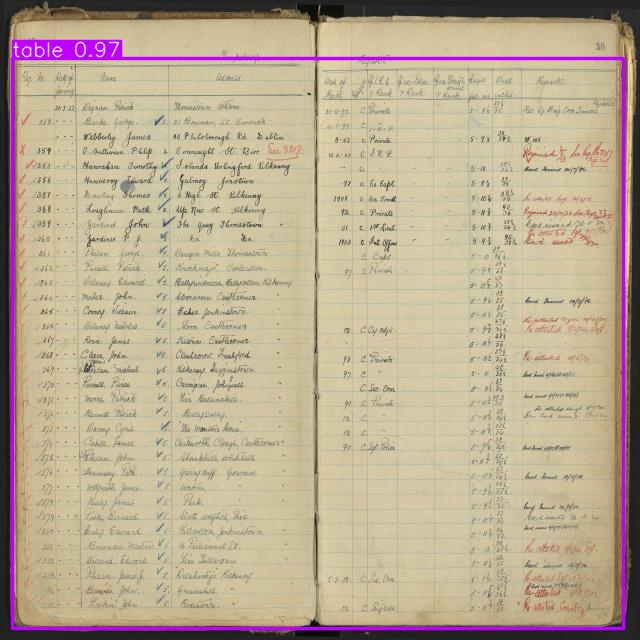

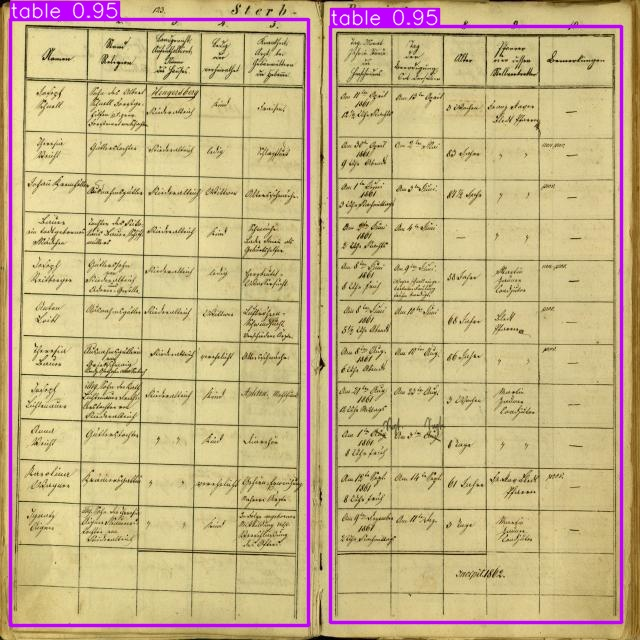

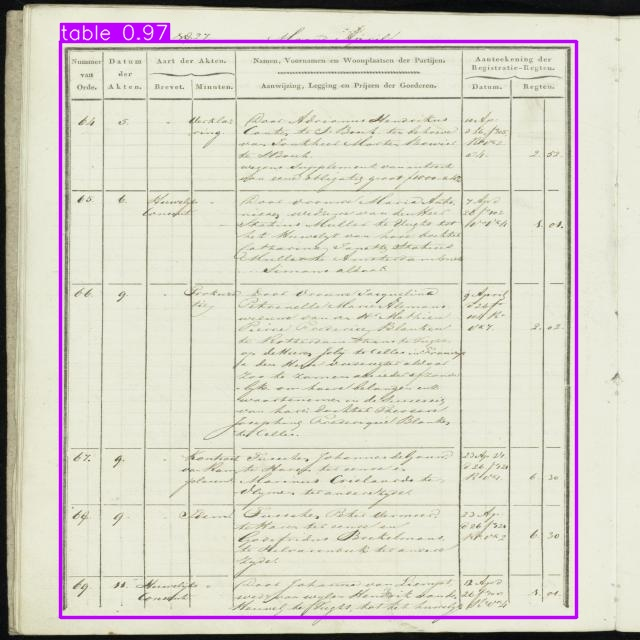

In [ ]:
import glob
from IPython.display import Image, display

# Define the base path where the folders are located
base_path = '/content/runs/detect'

# List all directories that start with 'predict' in the base path
subfolders = [os.path.join(base_path, d) for d in os.listdir(base_path)
              if os.path.isdir(os.path.join(base_path, d)) and d.startswith('predict')]

# Find the latest folder by modification time
latest_folder = max(subfolders, key=os.path.getmtime)

image_paths = glob.glob(f'{latest_folder}/*.jpg')[:3]

# Display each image
for image_path in image_paths:
    display(Image(filename=image_path, width=600))
    print("\n")